# Fourier Reconstruction 2D
---
**Notebook 2 — 2026**
<div style="font-size:15px; padding:8px; margin:2px; font-weight:600; background-color:#E80808; color:white;text-align:center;">
    <div style=" ">
        Introduction to Multidimensional Fourier Transform
    </div>
</div>
<div style="border-bottom: 1px gray dotted; padding:8px;margin:2px;text-align:center; font-size:15px; color:#444;">
<i>Daniel Sage — École Polytechnique Fédérale de Lausanne (EPFL)</i>
</div>

**Important notice**: These interactive notebooks complement the lecture and are not self-contained; in-class explanations are required.

In [45]:
import numpy as np, matplotlib.pyplot as plt
from skimage import data, transform, draw, io
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from matplotlib.patches import Circle

#img = data.camera()
img = io.imread('car_pad.tif')
size=128
img = transform.resize(img, (size,size), anti_aliasing=True)

def fft2c(x): return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(F): return np.real(np.fft.ifft2(np.fft.ifftshift(F)))
def snr(x,y): return 10*np.log10(np.mean(x*x)/(np.mean((x-y)**2)+1e-12))
def radial_grid(n):a=(np.arange(n)-n//2)/n; X,Y=np.meshgrid(a,a); return np.sqrt(X*X+Y*Y)
def showim(ax,img,t,vmin=None,vmax=None):
    ax.imshow(img,cmap="gray",vmin=vmin,vmax=vmax); ax.set_title(t); ax.axis("off")
def showFM(ax,F,t):
    ax.imshow(np.log(np.abs(F)+1e-12),cmap="gray"); ax.set_title(t); ax.axis("off")
def plotsig(ax, x, s, title):
    ax.plot(x, s); ax.set_title(title); ax.grid(True, lw=.4, color="0.85"); ax.margins(0.01)
def plotFM(ax, x, s, title):
    rs = np.abs(s)+1e-12; ax.plot(x, rs); ax.set_title(title); ax.set_yscale("log"); ax.grid(True, lw=.4, color="0.85"); ax.margins(0.01)

## 2.1 Perfect reconstruction

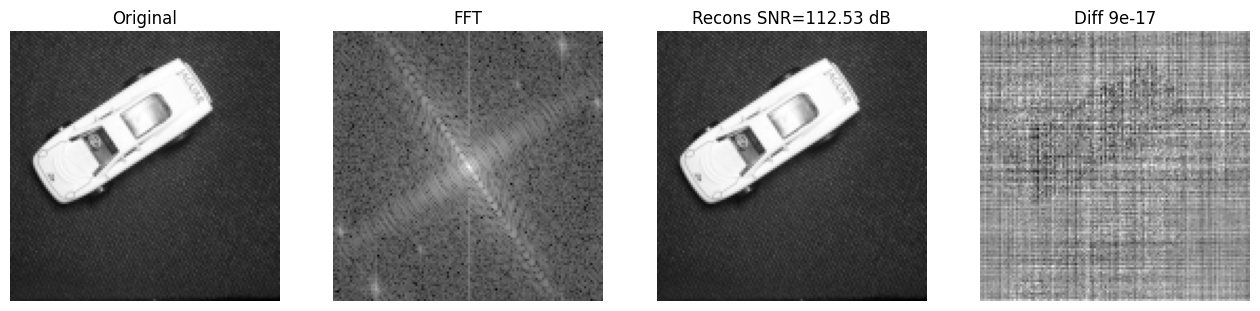

In [46]:
R=ifft2c(fft2c(img))
fig,ax=plt.subplots(1,4,figsize=(16,4))
showim(ax[0],img,"Original")
showFM(ax[1],fft2c(img),"FFT"); 
showim(ax[2],R,f"Recons SNR={snr(img,R):.2f} dB")
showim(ax[3],img-R,f"Diff {np.mean(np.abs(img-R)):3.0e}")
plt.show()

## 2.2 Partial reconstruction (% Non Zero-Coefficients)

In [47]:
F0 = fft2c(img); Rg = radial_grid(size)

@interact(log_nzc=FloatSlider(min=-2, max=0, step=0.05, value=-1),
          mode=Dropdown(options=["low","high","random","largest"], value="low"))
def partial_reconstruction(log_nzc, mode):
    nzc = 10**log_nzc
    if mode=="low": M = Rg <= nzc * Rg.max()
    elif mode=="high": M = Rg >= (1-nzc) * Rg.max()
    elif mode=="random": M = np.random.rand(size,size) < nzc
    else:
        v = np.abs(F0).ravel(); k = max(1, int(nzc * v.size))
        t = np.partition(v, -k)[-k]; M = np.abs(F0) >= t
    Fm = F0 * M; r = ifft2c(Fm)

    fig,ax = plt.subplots(1,4,figsize=(16,4))
    showim(ax[0], img, "Original")
    showFM(ax[1], F0, f"FFT nzc={(nzc*100):3.1f}%"); ax[1].plot(*np.where(M),'r.',ms=1)
    showim(ax[2], r, f"Recon SNR={snr(img,r):.2f} dB")
    showim(ax[3], img-r, f"Diff ‖·‖={np.linalg.norm(img-r):.2e}")
    plt.show()

interactive(children=(FloatSlider(value=-1.0, description='log_nzc', max=0.0, min=-2.0, step=0.05), Dropdown(d…

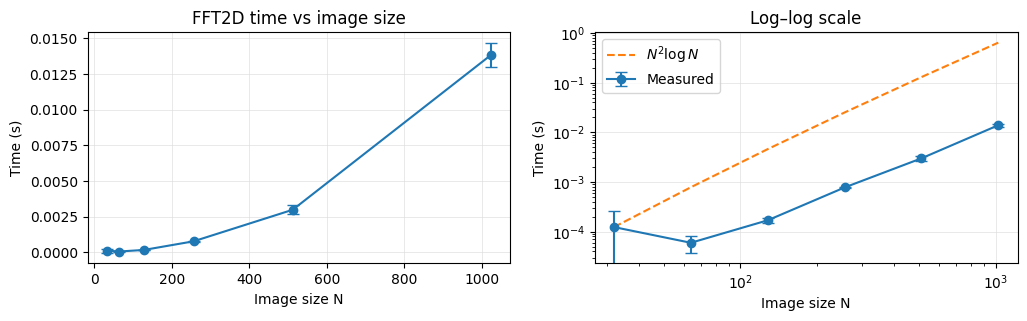

In [48]:
import time
sizes = [32, 64, 128, 256, 512, 1024]
means, stds = [], []
for p in sizes:
    img_t = np.random.rand(p,p)
    t = []
    for i in range(10):
        t0 = time.perf_counter(); _ = np.fft.fft2(img_t); t.append(time.perf_counter() - t0)
    means.append(np.mean(t))
    stds.append(np.std(t))

fig,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].errorbar(sizes, means, yerr=stds, fmt="o-", capsize=4)
ax[0].set_xlabel("Image size N"); ax[0].set_ylabel("Time (s)"); ax[0].set_title("FFT2D time vs image size")
ax[0].grid(True, lw=.4, color="0.85")
ax[1].errorbar(sizes, means, yerr=stds, fmt="o-", label="Measured", capsize=4)
ax[1].loglog(sizes,[means[0]*(s/sizes[0])**2*np.log2(s/sizes[0]+1) for s in sizes], "--", label=r"$N^2\log N$")
ax[1].set_xlabel("Image size N"); ax[1].set_ylabel("Time (s)"); ax[1].set_title("Log–log scale")
ax[1].legend(); ax[1].grid(True, lw=.4, color="0.85")
plt.show()

## 2.3 Canonical Signals

In [49]:
@interact(shape=Dropdown(options=[ "rect","dirac","gaussian","random","constant", "1 x wave2d","3 x wave2d"], value="gaussian"))
def canonical_signals_FT(shape):
    p = 128
    np.random.seed(0)
    x = np.arange(p)
    f = np.fft.fftshift(np.fft.fftfreq(p))
    X,Y = np.meshgrid(x,x,indexing="ij")
    if shape=="rect": s = np.zeros(p); s[p//4:3*p//4] = 1; img = np.outer(s,s)
    elif shape=="dirac": s = np.zeros(p); s[p//2] = 1; img = np.outer(s,s)
    elif shape=="gaussian": sig = p/20; s = np.exp(-(x-p//2)**2/(2*sig*sig)); img = np.outer(s,s)
    elif shape=="random": s = np.random.rand(p); img = np.outer(s,s)
    elif shape=="constant": s = np.ones(p); img = np.outer(s,s)
    elif shape=="1 x wave2d": fx, fy = 5/p, 2/p; img = np.cos(2*np.pi*(fx*X + fy*Y)); s = img[p//2,:]
    else: img = (np.cos(2*np.pi*(5/p*X)) + np.cos(2*np.pi*(5/p*(0.5*X+1.5*Y))) + np.cos(2*np.pi*(5/p*(0.5*X-5*Y)))); s = img[p//2,:]
    S1 = np.fft.fftshift(np.fft.fft(s))
    F2 = fft2c(img)

    fig,ax = plt.subplots(1,4,figsize=(16,4))
    plotsig(ax[0], x, s, "1D signal")
    plotFM(ax[1], f, S1, "FFT 1D |·| (log)")
    showim(ax[2], img, "2D signal")
    showFM(ax[3], F2, "FFT 2D |·| (log)")
    plt.show()

interactive(children=(Dropdown(description='shape', index=2, options=('rect', 'dirac', 'gaussian', 'random', '…